<script src="//yihui.org/js/math-code.js"></script>
<!-- Just one possible MathJax CDN below. You may use others. -->
<script async
  src="//mathjax.rstudio.com/latest/MathJax.js?config=TeX-MML-AM_CHTML">
</script>
## Piotroski F-Score Trading Strategy

Piotroski's F-Score strategy is an algorithmic trading strategy based on a fundamental analysis of the historical financial statements made by a comapny's management. It is described in the paper by Joseph D. Piotroski titled *"Value Investing: The use of historical financial information to separate winners from losers"*.

Using this strategy we can select from a universe of all value firms (i.e. undervalued firms or firms with high ratio of book value to market value), the firms which have been incorrectly undervalued and have a strong potential to get the correct market valuation in the near future i.e. *winners* and the firms which are rightly valued low and are expected to go down i.e. *losers*. The final trading strategy will be to go long on the winners and short on the losers.

**Piotroski's F-Score** is a sum of 9 elements consiting of 3 types of measures viz. 4 profitability measures, 3 capital structure measures and 2 operational efficiency measures.

**Components of Piotroski's F-score**:

**I. Profitability measures**:
1. **ROA** : This component signifies the level of profitability of a firm. ROA or Return on Assets is measured as the net income before extraordinary items scaled by the beginning of the year total assets. The correspoding F-Score element, F_ROA = 1 if ROA > 0 and 0 otherwise.

2. **CFO** : This component signifies the level of cash flows of a firm. CFO or Cash Flow from Operations is caluclated as the total cash flow from operating activities (i.e. inflows and outflows from regular business activities obtained from the Cash Flow statement) scaled by the beginning of the year total assets. The correspnding F-Score element, F_CFO = 1 if CFO > 0 and 0 otherwise.

3. **$\Delta$ROA** : This component signifies the change in profitability of a firm. $\Delta$ROA is measured as the current year's ROA minus the previous year's ROA. The corresponding F-Score element, F_$\Delta$ROA = 1 if $\Delta$ROA >0 and 0 otherwise.

4. **Accrual** : Accrual is the part of revenue which the firm has not received in cash. Accrual is measured as ROA minus CFO i.e. the net income before extraordinary items minus cash flow from operations, the whole scaled by the beginning of the year total assets. The corresponding F-Score element F_ACCRUAL = 1 if Accrual < 0 and 0 otherwise.

**II. Capital Structure measures**:

5. **$\Delta$LEVER** : For distressed firms, increase in long-term debt is bad sign. Leverage is calculated as the total long term debt scaled by the average total asset. $\Delta$LEVER is euqal to the current year's leverage minus the previous year's leverage. The corresponsing F-Score element, F_$\Delta$LEVER = 1 if $\Delta$LEVER < 0 and 0 otherwise.

6. **$\Delta$LIQUID** : This component measures the short-term liquidity. Increase in short-term debt => decrease in current ratio/liquidity => bad for distressed firms. Current ratio is defined as the ratio of the firm's total current assets and current liabilities. $\Delta$LIQUID is measured as the current year's current ratio minus the previous year's current ratio. The corresponding, F-Score element, F_$\Delta$LIQUID = 1 if $\Delta$LIQUID > 0 and 0 otherwise.

7. **EQ_OFFER** : For distressed firms repeatedly raising money is not a good sign. EQ_OFFER = 1 if the firm didnot issue common equity in the year preceding the portfolio formation, 0 otherwise.

**III. Operating efficiency measures**:\
ROA = $\frac{\rm Profit}{\rm Total Assets}$ = $\frac{\rm Profit}{\rm Sales} \times \frac{\rm Sales}{\rm Total Assets}$ = $Margin \times Turnover$


8. **$\Delta$MARGIN** : \
GMO = Gross Margin Ratio = Gross Profit scaled by total Sales.\
$\Delta$MARGIN = current year's GMO - previous year's GMO. The corresponding F-Score element, F_$\Delta$MARGIN = 1 if $\Delta$MARGIN > 0, 0 otherwise.

9. **$\Delta$TURN** : \
ATR = Asset Turnover Ratio = Total Sales scaled by the beginning of the year total Assets\
$\Delta$TURN = Current year's ATR - previous year's ATR. The corresponding F-Score element, F_$\Delta$TURN = 1 if $\Delta$TURN > 0, 0 otherwise.

### Importing necessary modules

In [479]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
from datetime import date
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from format import format

### Getting the list of stocks from NASDAQ

In [555]:
# getting a list of all the stocks from NASDAQ with Market Cap > 0

df = pd.read_csv('nasdaq_screener.csv')
df = df[df['Market Cap'] > 0]
df.reset_index(inplace=True, drop=True)
stocks = list(df['Symbol'])
len(stocks)

5743

### Functions for web-scraping financial statement tables
Next, we will define some functions to scrape the marketwatch.com website to get the financial data of the firms required for calculating the F-Score elements, using the financial statements of the firms given on marketwatch.com

In [556]:
# functions for web-scraping financial statement tables from marketwatch.com


def get_table_simple(table,is_table_tag=True):
    '''
    This function will use an html table element and will return 
    a list of lists representing the table
    
    inputs:
    table : an html element
    is_table_tag :  True or False (whether the table is an actual html table 
    element or a simple rows and columns separated by div elements.
    
    output : returns the table in a list of lists form
    '''
    elems = table.find_all('tr') if is_table_tag else get_children(table)
    table_data = list()
    for row in elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag or len(str(item).replace("\n","").strip())>0]

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string



# function for reading balance sheet data from marketwatch.com using a stock ticker
def get_balance_sheet_data(ticker,yr):
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the balance sheet of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total assets, total current assets, total liabilities, total current liabilities, 
    long-term debt and total common equity)
    '''
    
    urlbalancesheet = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/balance-sheet'
    text_soup_balancesheet = BeautifulSoup(requests.get(urlbalancesheet).text,"lxml") #read in
    tables_balancesheet = text_soup_balancesheet.findAll('div', {'class': 'financials'})
    
    bs_assets_table = get_table_simple(tables_balancesheet[0],is_table_tag=True)
    bs_assets_table[0].remove('5-year trend')
    df_assets = pd.DataFrame.from_records(bs_assets_table[1:],columns=bs_assets_table[0])
    df_assets.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_assets['Item'] = df_assets['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    bs_liabilities_table = get_table_simple(tables_balancesheet[1],is_table_tag=True)
    bs_liabilities_table[0].remove('5-year trend')
    df_liabilities = pd.DataFrame.from_records(bs_liabilities_table[1:],columns=bs_liabilities_table[0])
    df_liabilities.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_liabilities['Item'] = df_liabilities['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_assets.columns or yr not in df_liabilities.columns:
        return {'longTermDebt': None,'totalAssets': None, 'totalCurrentAssets': None, 'totalLiabilities': None, 'totalCurrentLiabilities': None, 'commonStock': None}

    totalassets = text_parse(df_assets[df_assets.Item=='Total Assets'][yr].values[0])
    totalcurrentassets = text_parse(df_assets[df_assets.Item=='Total Current Assets'][yr].values[0])
    
    longtermdebt = text_parse(df_liabilities[df_liabilities.Item == 'Long-Term Debt'][yr].values[0])
    totalliabilities = text_parse(df_liabilities[df_liabilities.Item == 'Total Liabilities'][yr].values[0])
    totalcurrentliabilities = text_parse(df_liabilities[df_liabilities.Item == 'Total Current Liabilities'][yr].values[0])
    commonequity = text_parse(df_liabilities[df_liabilities.Item == 'Common Equity (Total)'][yr].values[0])
    
    return {'longTermDebt':longtermdebt,'totalAssets':totalassets, 'totalCurrentAssets': totalcurrentassets, 'totalLiabilities':totalliabilities, 'totalCurrentLiabilities':totalcurrentliabilities, 'commonStock':commonequity}




# function for reading income statement data from marketwatch.com using a stock ticker
def get_income_statement_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the income statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. Net Income, Gross Profit and Total Revenue)
    '''
    
    url_financials = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials'
    text_soup_financials = BeautifulSoup(requests.get(url_financials).text,"lxml") #read in
    tables_incomestatement = text_soup_financials.findAll('div', {'class': 'financials'})
    
    is_table = get_table_simple(tables_incomestatement[0],is_table_tag=True)
    is_table[0].remove('5-year trend')
    df_is = pd.DataFrame.from_records(is_table[1:],columns=is_table[0])
    df_is.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_is['Item'] = df_is['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_is.columns:
        return {'netIncome': None,'grossProfit': None,'totalRevenue': None}
    
    netincome =text_parse(df_is[df_is['Item']=='Net Income'][yr].values[0])
    grossprofit = text_parse(df_is[df_is['Item']=='Gross Income'][yr].values[0])
    totalsales = text_parse(df_is[df_is['Item']=='Sales/Revenue'][yr].values[0])
    
    return {'netIncome': netincome,'grossProfit': grossprofit,'totalRevenue': totalsales}




# function for reading cash flow statement data from marketwatch.com using a stock ticker
def get_cash_flow_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the cash flow statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total cash from operating activities)
    '''
        
    urlcashflow = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/cash-flow'
    text_soup_cashflow = BeautifulSoup(requests.get(urlcashflow).text,"lxml") #read in
    tables_cashflow = text_soup_cashflow.findAll('div', {'class': 'financials'})
    cf_table = get_table_simple(tables_cashflow[0],is_table_tag=True)
    
    cf_table[0].remove('5-year trend')
    df_cf = pd.DataFrame.from_records(cf_table[1:],columns=cf_table[0])
    df_cf.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_cf['Item'] = df_cf['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_cf.columns:
        return {'totalCashFromOperatingActivities': None}

    cashflowoperating = text_parse(df_cf[df_cf['Item']=='Net Operating Cash Flow'][yr].values[0])
    
    return {'totalCashFromOperatingActivities': cashflowoperating}




def text_parse(text):
    '''
    This function to convert the string outputs of the 
    financial statements to float values  
    '''
    text = text.strip('(').strip(')').strip('$').strip(' ')
    if text == '-' or text == '' or text == 'N/A':
        return 0    
    elif text[-1] == 'T':
        return float(text.strip('T'))*1e12
    elif text[-1] == 'B':
        return float(text.strip('B'))*1e9
    elif text[-1] == 'M':
        return float(text.strip('M'))*1e6
    elif text[-1] == 'K':
        return float(text.strip('K'))*1e3
    else:
        return(float(text))
        

### Getting the Book to Market Value ratios (BM) for all the stocks

In [576]:
# getting the book values and market values, and their ratios for all the stocks in the list (wherever available) 
# for the previous year

#Book_Value_list = []
#Market_Cap_list= []
#B2M_dict = dict()
#i=0
for symbol in stocks:
    i+=1
    try:
        #print(symbol)
        Total_Assets_cur_year = get_balance_sheet_data(symbol,'2020')['totalAssets']
        Total_Liabilities_cur_year = get_balance_sheet_data(symbol,'2020')['totalLiabilities']
        Book_Value = Total_Assets_cur_year-Total_Liabilities_cur_year
        Book_Value_list.append(Book_Value)
        Market_Cap = df[df.Symbol==symbol]['Market Cap'].values[0]
        Market_Cap_list.append(Market_Cap)
        B2M = Book_Value/Market_Cap
        B2M_dict[symbol]=B2M
    except (IndexError, ValueError, TypeError) as error:
        pass

    sorted_B2M_dict = {k: v for k, v in sorted(B2M_dict.items(), key=lambda item: item[1], reverse=True)}

In [577]:
import json

# writing the dictionary containing B2M values of all the firms to a file
with open('B2M_dict.txt', 'w') as file:
     file.write(json.dumps(B2M_dict))

### BM ratio distribution

In [579]:
# mean and standard deviations of the book to market value ratios of all the stocks
np.mean(list(B2M_dict.values())), np.std(list(B2M_dict.values()))

(4.193231510395126, 82.52421205439973, 2690)

In [580]:
# converting the values of the output dictionary to a list
B2M_values = list(B2M_dict.values())

Text(0, 0.5, 'Frequency')

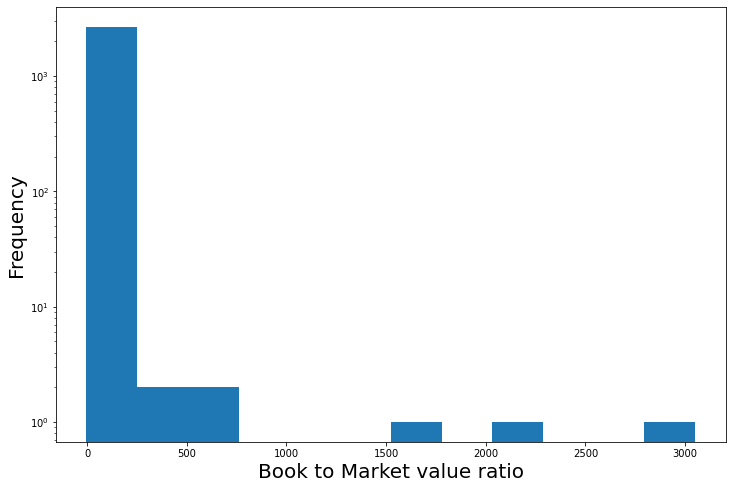

In [581]:
# plotting the histogram of the book to market value ratios
#px.histogram(x=B2M_dict.values(),log_y=True, nbins=12, labels={'x':'Book to Market value ratio', 'y':'Count'})
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(B2M_values,bins=12, log=True)
ax.set_xlabel('Book to Market value ratio', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

### Selecting high BM firms

In [582]:
# threshold value for the top 25% book to market ratios
np.quantile(B2M_values, 0.75)

0.5685465346008152

In [583]:
# selecting the top 25% book to market ratio firms for our sample of high book to market value firms
q = 0.75
high_B2M_dict = {k:v for k,v in B2M_dict.items() if v>np.quantile(B2M_values, q)}
np.mean(list(high_B2M_dict.values())), np.std(list(high_B2M_dict.values()))

(16.171750550938068, 164.4056576395376)

In [584]:
# writing the dictionary containing the B2M values of high B2M firms to a file
with open('high_B2M_dict.txt', 'w') as file:
     file.write(json.dumps(high_B2M_dict))

### Calculating F-Scores for the high BM firms

In [586]:
# getting the 9 different elements of Piotroski's F-Score for or sample of high book to market value firms

columns = ['symbol', 'F_ROA', 'F_CFO', 'F_delta_ROA', 'F_ACCRUAL', 'F_delta_LEVER', 'F_delta_LIQUID', 'EQ_OFFER', 'F_delta_MARGIN', 'F_delta_TURN', 'F_SCORE']
F_Score_df = pd.DataFrame(columns=columns)

for symbol in list(high_B2M_dict.keys()):
    #print(symbol)
    
    try:
        # Balance Sheet Data
        bs_data_cur_year = get_balance_sheet_data(symbol,'2020')
        bs_data_last_year = get_balance_sheet_data(symbol,'2019')
        bs_data_lasttolast_year = get_balance_sheet_data(symbol,'2018')

        # Income Statement Data
        is_data_cur_year = get_income_statement_data(symbol,'2020')
        is_data_last_year =  get_income_statement_data(symbol,'2019')

        # Cash Flow Data
        cf_data_cur_year = get_cash_flow_data(symbol,'2020')


        Total_Assets_cur_year = bs_data_cur_year['totalAssets']
        Total_Assets_beg_cur_year = bs_data_last_year['totalAssets']
        Total_Assets_beg_last_year = bs_data_lasttolast_year['totalAssets']

        Net_Income_cur_year = is_data_cur_year['netIncome']
        Net_Income_last_year = is_data_last_year['netIncome']

        Cash_Flow_From_operations_cur_year = cf_data_cur_year['totalCashFromOperatingActivities']

        Total_Long_Term_Debt_cur_year = bs_data_cur_year['longTermDebt']
        Total_Long_Term_Debt_last_year = bs_data_last_year['longTermDebt']

        Current_Assets_cur_year = bs_data_cur_year['totalCurrentAssets']
        Current_Assets_last_year = bs_data_last_year['totalCurrentAssets']

        Current_Liabilities_cur_year = bs_data_cur_year['totalCurrentLiabilities']
        Current_Liabilities_last_year = bs_data_last_year['totalCurrentLiabilities']

        Common_Stock_cur_year = bs_data_cur_year['commonStock']
        Common_Stock_last_year = bs_data_last_year['commonStock']

        Gross_Profit_cur_year = is_data_cur_year['grossProfit']
        Gross_Profit_last_year = is_data_last_year['grossProfit']

        Total_Revenue_cur_year = is_data_cur_year['totalRevenue']
        Total_Revenue_last_year = is_data_last_year['totalRevenue']

        financials = [Total_Assets_cur_year, Total_Assets_beg_cur_year, Total_Assets_beg_last_year,
                     Net_Income_cur_year, Net_Income_last_year,
                     Cash_Flow_From_operations_cur_year,
                     Total_Long_Term_Debt_cur_year, Total_Long_Term_Debt_last_year,
                     Current_Assets_cur_year, Current_Assets_last_year,
                     Current_Liabilities_cur_year, Current_Liabilities_last_year,
                     Common_Stock_cur_year, Common_Stock_last_year,
                     Gross_Profit_cur_year, Gross_Profit_last_year,
                     Total_Revenue_cur_year, Total_Revenue_last_year]

        if None in financials:
            continue

        else:

            ROA_cur_year = Net_Income_cur_year/Total_Assets_beg_cur_year
            F_ROA = 1 if ROA_cur_year > 0 else 0

            CFO = Cash_Flow_From_operations_cur_year/Total_Assets_beg_cur_year
            F_CFO = 1 if CFO > 0 else 0

            ROA_last_year = Net_Income_last_year/Total_Assets_beg_last_year
            delta_ROA = ROA_cur_year - ROA_last_year
            F_delta_ROA = 1 if delta_ROA > 0 else 0

            ACCRUAL = (Net_Income_cur_year - Cash_Flow_From_operations_cur_year)
            F_ACCRUAL = 1 if ACCRUAL < 0 else 0

            Average_Total_Asset_cur_year = (Total_Assets_cur_year+Total_Assets_beg_cur_year)/2
            Average_Total_Asset_last_year = (Total_Assets_beg_cur_year+Total_Assets_beg_last_year)/2
            Leverage_cur_year = Total_Long_Term_Debt_cur_year/Average_Total_Asset_cur_year 
            Leverage_last_year = Total_Long_Term_Debt_last_year/Average_Total_Asset_last_year
            delta_LEVER = Leverage_cur_year - Leverage_last_year
            F_delta_LEVER = 1 if delta_LEVER < 0 else 0

            Current_Ratio_cur_year = Current_Assets_cur_year/Current_Liabilities_cur_year
            Current_Ratio_last_year = Current_Assets_last_year/Current_Liabilities_last_year
            delta_LIQUID = Current_Ratio_cur_year - Current_Ratio_last_year
            F_delta_LIQUID = 1 if delta_LIQUID > 0  else 0

            Common_Equities_issued_in_prev_year = Common_Stock_cur_year - Common_Stock_last_year
            EQ_OFFER = 1 if Common_Equities_issued_in_prev_year <= 0 else 0

            GMO_cur_year = Gross_Profit_cur_year/Total_Revenue_cur_year
            GMO_last_year = Gross_Profit_last_year/Total_Revenue_last_year
            delta_MARGIN = GMO_cur_year - GMO_last_year
            F_delta_MARGIN = 1 if delta_MARGIN > 0 else 0

            ATR_cur_year = Total_Revenue_cur_year/Total_Assets_beg_cur_year
            ATR_last_year = Total_Revenue_last_year/Total_Assets_beg_last_year
            delta_TURN = ATR_cur_year - ATR_last_year
            F_delta_TURN = 1 if delta_TURN > 0 else 0

            F_SCORE = F_ROA + F_CFO + F_delta_ROA + F_ACCRUAL + F_delta_LEVER + F_delta_LIQUID + EQ_OFFER + F_delta_MARGIN + F_delta_TURN

            F_Score_df = F_Score_df.append(pd.DataFrame([[symbol ,F_ROA, F_CFO, F_delta_ROA, F_ACCRUAL, F_delta_LEVER, F_delta_LIQUID, EQ_OFFER, F_delta_MARGIN, F_delta_TURN, F_SCORE]],columns=columns),ignore_index=True)
    except (IndexError, ZeroDivisionError) as error:
        pass

### F-Score results for the high BM firms

In [587]:
# resulting dataframe
#F_Score_df.drop_duplicates(subset=['symbol'],keep='first',inplace=True)
F_Score_df

,symbol,F_ROA,F_CFO,F_delta_ROA,F_ACCRUAL,F_delta_LEVER,F_delta_LIQUID,EQ_OFFER,F_delta_MARGIN,F_delta_TURN,F_SCORE
0,AA,1,1,0,1,0,1,1,0,0,5
1,AAOI,1,1,0,0,1,0,0,0,1,4
2,AAWW,1,1,1,1,1,1,0,1,1,8
3,ABEV,1,1,0,1,1,0,0,0,1,5
4,ACA,1,1,0,1,0,0,0,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...
613,XOM,1,1,1,0,0,1,1,0,0,5
614,XRX,1,1,0,1,0,1,1,0,0,5
615,YPF,1,1,1,1,1,0,0,0,0,5
616,ZEUS,1,1,1,1,1,0,1,1,0,7


In [588]:
# writing output dataframe to a file
F_Score_df.to_csv('high_B2M_firms_F_Score_table.csv', index=False)

So at the end, we get F-Score results of 466 firms. The **topmost F-Scores** belong to firms whose **fundamentals are imporoving** and are therefore **potential winners**. 

The **bottommost F-Scores** belong to firms whose **fundamentals are worsening** and are therefore **potential losers**.

The optimum trading strategy is to **long the winners and short the losers**.

### Distribution of F-Scores for high BM firms

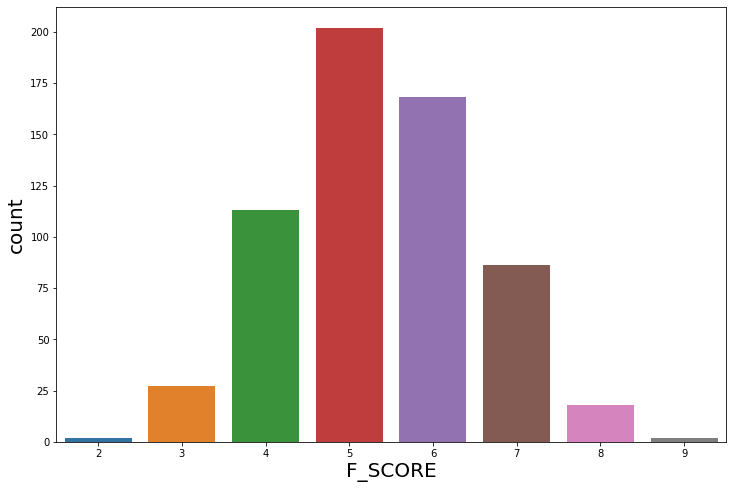

In [589]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='F_SCORE',data=F_Score_df,ax=ax)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

In [590]:
len(F_Score_df[F_Score_df.F_SCORE==2]), len(F_Score_df[F_Score_df.F_SCORE==3]), len(F_Score_df[F_Score_df.F_SCORE==8]), len(F_Score_df[F_Score_df.F_SCORE==9])

(2, 27, 18, 2)

### Deciding winners and losers

As we see in this plot, we didn't find any firms with an F-Score of 0. We can choose the ~2 firms that have the F-Score of 9 along with the 18 firms with the F-Score of 8 for the long positions and the ~27 firms with the F-Score of 3 along with the 2-firms with the F-Score of 2, for the short positions.

### Potential Winners (Long Positions)

In [591]:
print(F_Score_df[F_Score_df.F_SCORE==9]['symbol'])
print(F_Score_df[F_Score_df.F_SCORE==8]['symbol'])

376    NGD
440    PVG
Name: symbol, dtype: object
2       AAWW
44      ATNI
47       AUY
82       BTG
83       BTI
94       CBD
113      CLW
121     CNSL
153      DHT
155     DISH
193     EURN
319      LPG
328      MBT
366      NAT
384     NOMD
443    QRTEA
444    QRTEB
508     STNG
Name: symbol, dtype: object


### Potential Losers (Short Positions)

In [592]:
print(F_Score_df[F_Score_df.F_SCORE==2]['symbol'])
print(F_Score_df[F_Score_df.F_SCORE==3]['symbol'])

14     AINC
493    SMLP
Name: symbol, dtype: object
9      AENZ
57      BDL
59     BEDU
74      BLU
99     CECE
107     CHT
190     ETM
209    FLMN
211    FLXS
214     FMX
215    FONR
227    GENC
251    HAPP
267     HUN
276     IMO
281     IVC
285     JOB
317     LND
321     LRN
348     MOV
354    MSGE
369      NC
394    NTWK
406    OMAB
424     PHX
451     REX
498    SOHU
Name: symbol, dtype: object
